# Spoken commands example
This example uses an audio classifier model from a Tensorflow tutorial:
https://www.tensorflow.org/tutorials/sequences/audio_recognition

**N.B. This script downloads a large (2.3GB) speech commands dataset!**

In [98]:
import sys
sys.path.append('..')
from pathlib import Path
import tarfile
import shutil
import numpy as np
import pandas as pd
from scipy.io.wavfile import read, write
from sklearn.metrics import confusion_matrix
from src.problemgenerator.series import Series
from src.problemgenerator.tuple import Tuple
from src.problemgenerator.filters import ClipWAV, ApplyToTuple
from src.plotting.utils import visualize_confusion_matrix

In [3]:
# In this cell we download the dataset unless it is already present.
# If you have downloaded and extracted the dataset into a different directory,
# change the data_dir variable accordingly.

data_url = "https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz"
fname = "speech_commands_v0.02.tar.gz"
data_dir = Path.home() / "datasets/speech_data"

if not data_dir.exists():
    !mkdir -p {data_dir}
    !wget {data_url} -P {data_dir}
    tarfile.open(data_dir / fname, "r:gz").extractall(data_dir)

In [4]:
trained_cats = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [6]:
# If your dpEmu folder is not located directly under your home directory,
# change the example_path variable accordingly.

example_path = Path.home() / "dpEmu/src/examples/speech_commands"
category = "stop"
data_subset_dir = data_dir / category

In [7]:
fs = list(data_subset_dir.iterdir())
wavs = [read(f) for f in data_subset_dir.iterdir()]

In [8]:
wav_node = Tuple()
wav_node.addfilter(ApplyToTuple(ClipWAV("dyn_range"), 1))
root_node = Series(wav_node)

err_params = {"dyn_range": .3}
clipped = root_node.generate_error(wavs, err_params)

In [9]:
example_index = 22  # Arbitrarily chosen speech command example – try changing the index!

In [10]:
write('clipped.wav', 16000, clipped[example_index][1])

In [11]:
!aplay {fs[example_index]}

Playing WAVE '/home/jtmyllar/datasets/speech_data/stop/f2898d06_nohash_4.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


In [12]:
!aplay clipped.wav

Playing WAVE 'clipped.wav' : Signed 16 bit Little Endian, Rate 16000 Hz, Mono


In [13]:
# Define a function to filter out irrelevant output (e.g. Python deprecation warnings)
def filter_scores(output):
    return [line for line in output if "score" in line or ".wav" in line]

In [15]:
# You can also obtain the scores for an entire directory of .wav files in one command
scores_clean_dir = !python {example_path}/label_wav_dir.py \
--graph={example_path}/trained_model/my_frozen_graph.pb \
--labels={example_path}/trained_model/conv_labels.txt \
--wav_dir={data_subset_dir}

filter_scores(scores_clean_dir)

['8e523821_nohash_1.wav',
 'stop (score = 0.99988)',
 '_unknown_ (score = 0.00010)',
 'down (score = 0.00001)',
 '7e6bd776_nohash_0.wav',
 'stop (score = 0.90644)',
 '_unknown_ (score = 0.03362)',
 'down (score = 0.01422)',
 'ffb86d3c_nohash_0.wav',
 'stop (score = 0.95472)',
 'up (score = 0.04304)',
 'off (score = 0.00085)',
 '4c6944d6_nohash_0.wav',
 'stop (score = 0.53910)',
 'up (score = 0.31081)',
 'go (score = 0.08747)',
 '23da904f_nohash_4.wav',
 'stop (score = 0.96501)',
 'up (score = 0.03421)',
 '_unknown_ (score = 0.00064)',
 '07089da9_nohash_3.wav',
 'stop (score = 0.95420)',
 'up (score = 0.03873)',
 '_unknown_ (score = 0.00419)',
 '012187a4_nohash_1.wav',
 'stop (score = 0.97911)',
 '_unknown_ (score = 0.01058)',
 'up (score = 0.00352)',
 '3b195250_nohash_0.wav',
 'stop (score = 0.99850)',
 'up (score = 0.00147)',
 '_unknown_ (score = 0.00002)',
 '540d8427_nohash_0.wav',
 'no (score = 0.34321)',
 'go (score = 0.13103)',
 'up (score = 0.11262)',
 'c5e3817f_nohash_0.wav',
 '

In [16]:
def get_guesses(scores):
    scores = filter_scores(scores)
    if len(scores) % 4 != 0:
        raise ValueError(f"Expected scores list to have a length divisible by 4 after filtering but got length {len(scores)}")
    num_files = len(scores) / 4
    fnames = scores[0::4]
    guesses = [guess.split(' ')[0] for guess in scores[1::4]]
    return zip(fnames, guesses)

In [17]:
def score_directory(directory):
    scores = !python {example_path}/label_wav_dir.py \
        --graph={example_path}/trained_model/my_frozen_graph.pb \
        --labels={example_path}/trained_model/conv_labels.txt \
        --wav_dir={directory}
    return filter_scores(scores)

In [18]:
list(get_guesses(score_directory(data_subset_dir)))

[('8e523821_nohash_1.wav', 'stop'),
 ('7e6bd776_nohash_0.wav', 'stop'),
 ('ffb86d3c_nohash_0.wav', 'stop'),
 ('4c6944d6_nohash_0.wav', 'stop'),
 ('23da904f_nohash_4.wav', 'stop'),
 ('07089da9_nohash_3.wav', 'stop'),
 ('012187a4_nohash_1.wav', 'stop'),
 ('3b195250_nohash_0.wav', 'stop'),
 ('540d8427_nohash_0.wav', 'no'),
 ('c5e3817f_nohash_0.wav', 'stop'),
 ('f632210f_nohash_0.wav', 'stop'),
 ('ce7a8e92_nohash_1.wav', 'stop'),
 ('9ab86dd0_nohash_1.wav', 'stop'),
 ('a7200079_nohash_2.wav', 'stop'),
 ('ab5ae445_nohash_1.wav', 'stop'),
 ('ffa76c4a_nohash_0.wav', 'up'),
 ('b69002d4_nohash_2.wav', 'stop'),
 ('e3e0f145_nohash_1.wav', 'stop'),
 ('e882abb2_nohash_2.wav', 'stop'),
 ('146d97db_nohash_1.wav', 'stop'),
 ('837a0f64_nohash_2.wav', 'stop'),
 ('ef3367d9_nohash_7.wav', 'stop'),
 ('f2898d06_nohash_4.wav', 'stop'),
 ('0bd689d7_nohash_2.wav', 'stop'),
 ('845f8553_nohash_3.wav', 'stop'),
 ('211b928a_nohash_1.wav', 'stop'),
 ('4e6902d0_nohash_0.wav', 'stop'),
 ('97f4c236_nohash_2.wav', 'stop

In [64]:
def compare(data_root, category, clean_ext="_clean", err_ext="_err"):
    scores_clean = score_directory(data_root / (category + clean_ext))
    guesses_clean = get_guesses(scores_clean)
    scores_err = score_directory(data_root / (category + err_ext))
    guesses_err = get_guesses(scores_err)
    dfs = pd.DataFrame(guesses_clean, columns=["file", "clean_guess"]), pd.DataFrame(guesses_err, columns=["file", "err_guess"])
    res = pd.merge(*dfs, on="file", how="inner")
    res['true_label'] = category
    return res

In [65]:
df = compare(data_dir, category)

In [55]:
test_set_rel_paths = !cat {data_dir / "testing_list.txt"}
test_set_files = [data_dir / p for p in test_set_rel_paths]
categories = !cut -d'/' -f1 {data_dir / "testing_list.txt"} | sort -u

len(test_set_files), len(categories)

(11005, 35)

In [56]:
def errorify_directory(data_root_dir, dir_name, tree_root, err_params, inclusion_list=None):
    clean_data_dir = data_root_dir / dir_name
    if not clean_data_dir.exists():
        raise ValueError(f"Directory {clean_data_dir} does not exist.")
    err_data_dir = data_root_dir / (dir_name + "_err")
    if not err_data_dir.exists():
        !mkdir {err_data_dir}
    if not inclusion_list:
        inclusion_list = [f for f in clean_data_dir.iterdir() if ".wav" in str(f)]
    for file in inclusion_list:
        fname = file.name
        wav = read(file)
        clipped = tree_root.generate_error([wav], err_params)[0]
        err_file_path = err_data_dir / fname
        write(err_file_path, clipped[0], clipped[1])
    return err_data_dir

In [57]:
def errorify_list(data_files, categories, tree_root, err_params, copy_clean=False):
    data_root_dir = data_files[0].parents[1]
    print(f"data root dir: {data_root_dir}")
    for cat in categories:
        files_in_cat = [f for f in data_files if (cat + "/") in str(f)]
        print("category:", cat)
        print(f"{len(files_in_cat)}")
        errorify_directory(data_root_dir, cat, tree_root, err_params, inclusion_list=files_in_cat)
        if copy_clean:
            copy_dir = data_root_dir / (cat + "_clean")
            !mkdir {copy_dir}
            for file in files_in_cat:
                shutil.copy(file, copy_dir)
            

In [58]:
errorify_list(test_set_files, trained_cats, root_node, err_params, copy_clean=True)

data root dir: /home/jtmyllar/datasets/speech_data
category: yes
419
category: no
405
category: up
425
category: down
406
category: left
412
category: right
396
category: on
396
category: off
402
category: stop
411
category: go
402


In [82]:
df = compare(data_dir, trained_cats[0])
for cat in trained_cats[1:]:
    print(f"Combined data frame has size {df.size}")
    print(f"Processing category '{cat}'")
    results = compare(data_dir, cat)
    print(f"Results data frame has size {results.size}")
    df = pd.concat([df, results])

Combined data frame has size 1676
Processing category no
Results data frame has size 1620
Combined data frame has size 3296
Processing category up
Results data frame has size 1700
Combined data frame has size 4996
Processing category down
Results data frame has size 1624
Combined data frame has size 6620
Processing category left
Results data frame has size 1648
Combined data frame has size 8268
Processing category right
Results data frame has size 1584
Combined data frame has size 9852
Processing category on
Results data frame has size 1584
Combined data frame has size 11436
Processing category off
Results data frame has size 1608
Combined data frame has size 13044
Processing category stop
Results data frame has size 1644
Combined data frame has size 14688
Processing category go
Results data frame has size 1608


In [83]:
df

,file,clean_guess,err_guess,true_label
0,ffb86d3c_nohash_0.wav,yes,left,yes
1,e49428d9_nohash_4.wav,yes,right,yes
2,837a0f64_nohash_2.wav,yes,left,yes
3,97f4c236_nohash_2.wav,go,go,yes
4,fb7eb481_nohash_1.wav,yes,left,yes
5,d1bf406b_nohash_1.wav,yes,no,yes
6,4c6167ca_nohash_2.wav,yes,yes,yes
7,8fe67225_nohash_1.wav,yes,yes,yes
8,e41a903b_nohash_0.wav,yes,yes,yes
9,1b4c9b89_nohash_4.wav,yes,right,yes


In [92]:
df['model_name'] = "speech_rec"

In [94]:
df['dyn_range'] = err_params['dyn_range']

In [96]:
df['test'] = 1337.0

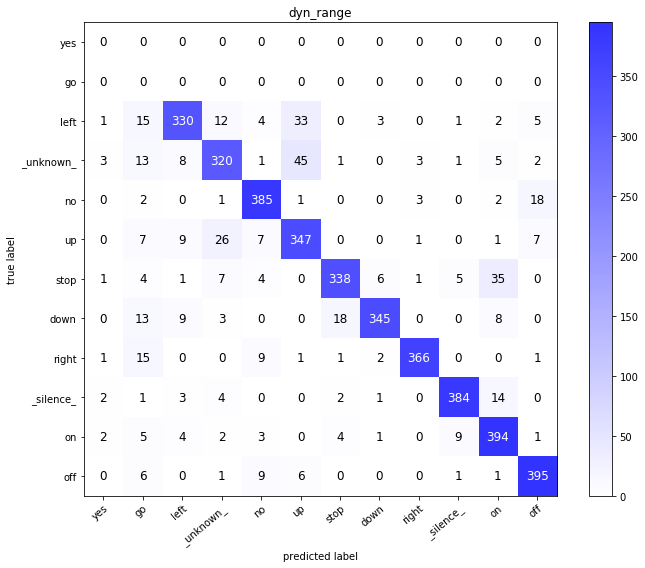

In [111]:
visualize_confusion_matrix(df, cm, 0, df['clean_guess'].unique(), "dyn_range", "true_label", "clean_guess")

In [88]:
cm = confusion_matrix(df['true_label'], df['clean_guess'])

In [110]:
df['clean_guess'].unique()

array(['yes', 'go', 'left', '_unknown_', 'no', 'up', 'stop', 'down',
       'right', '_silence_', 'on', 'off'], dtype=object)

In [89]:
cm

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  15, 330,  12,   4,  33,   0,   3,   0,   1,   2,   5],
       [  3,  13,   8, 320,   1,  45,   1,   0,   3,   1,   5,   2],
       [  0,   2,   0,   1, 385,   1,   0,   0,   3,   0,   2,  18],
       [  0,   7,   9,  26,   7, 347,   0,   0,   1,   0,   1,   7],
       [  1,   4,   1,   7,   4,   0, 338,   6,   1,   5,  35,   0],
       [  0,  13,   9,   3,   0,   0,  18, 345,   0,   0,   8,   0],
       [  1,  15,   0,   0,   9,   1,   1,   2, 366,   0,   0,   1],
       [  2,   1,   3,   4,   0,   0,   2,   1,   0, 384,  14,   0],
       [  2,   5,   4,   2,   3,   0,   4,   1,   0,   9, 394,   1],
       [  0,   6,   0,   1,   9,   6,   0,   0,   0,   1,   1, 395]])

In [ ]:
scores_clean = !python {example_path}/label_wav.py \
--graph={example_path}/trained_model/my_frozen_graph.pb \
--labels={example_path}/trained_model/conv_labels.txt \
--wav={fs[example_index]}

In [ ]:
scores_clipped = !python {example_path}/label_wav.py \
--graph={example_path}/trained_model/my_frozen_graph.pb \
--labels={example_path}/trained_model/conv_labels.txt \
--wav='clipped.wav'